In [3]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#Read file of joined Yelp Business & Review data
df = pd.read_csv('../Output_Folder/Santa_Barbara_Yelps.csv')
df.head(5)

,business_id,name,address,city,state,postal_code,review_count,review_id,stars,text
0,gebiRewfieSdtt17PTW6Zg,Hibachi Steak House & Sushi Bar,502 State St,Santa Barbara,CA,93101,488,pUycOfUwM8vqX7KjRRhUEA,3.0,Had a party of 6 here for hibachi. Our waitres...
1,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,389,L0jv8c2FbpWSlfNC6bbUEA,5.0,What a great addition to the Funk Zone! Grab ...
2,qO9dNNIvNbCBd8ZgjxMxgQ,HOME Santa Barbara,14 Parker Way,Santa Barbara,CA,93101,13,2u5Skti5mZam_-XTKPelvA,5.0,"Farmhouse, rustic, chic.Helpful staff with gre..."
3,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,2404,4zopEEPqfwm-c_FNpeHZYw,5.0,We were a bit weary about trying the Shellfish...
4,YbnJYHNp_fHbI-hcFg48vQ,Santa Barbara Adventure Company,32 E Haley St,Santa Barbara,CA,93101,195,HuWEnZr7-0HveaqXxyywgg,5.0,The kayaking tour at the Santa Cruz Island was...


Sentiment Analysis: https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

In [4]:
df = df[['text','stars']]
df.head()

,text,stars
0,Had a party of 6 here for hibachi. Our waitres...,3.0
1,What a great addition to the Funk Zone! Grab ...,5.0
2,"Farmhouse, rustic, chic.Helpful staff with gre...",5.0
3,We were a bit weary about trying the Shellfish...,5.0
4,The kayaking tour at the Santa Cruz Island was...,5.0


In [5]:
df.shape

(486, 2)

In [6]:
df=df.dropna()
df = df.reset_index(drop=True)
df.head()

,text,stars
0,Had a party of 6 here for hibachi. Our waitres...,3.0
1,What a great addition to the Funk Zone! Grab ...,5.0
2,"Farmhouse, rustic, chic.Helpful staff with gre...",5.0
3,We were a bit weary about trying the Shellfish...,5.0
4,The kayaking tour at the Santa Cruz Island was...,5.0


In [7]:
df.shape

(385, 2)

In [8]:
# Label the 4 & 5 star reviews as positive ('1') and 
# label the 1 & 2 star reviews as negative ('0'). 
# Drop the 3 star reviews as they are neutral

df['stars']=df['stars'].astype(int) #convert stars column to int

df=df[df['stars']!=3] #Drop 3-star reviews
df['label']=np.where(df['stars']>=4,1,0) #1-Positive, 0-Negative

df.head()

,text,stars,label
1,What a great addition to the Funk Zone! Grab ...,5,1
2,"Farmhouse, rustic, chic.Helpful staff with gre...",5,1
3,We were a bit weary about trying the Shellfish...,5,1
4,The kayaking tour at the Santa Cruz Island was...,5,1
5,The court house is very old and the art is gre...,4,1


In [9]:
df2 = df[['stars', 'label']]
df2.head()

,stars,label
1,5,1
2,5,1
3,5,1
4,5,1
5,4,1


In [10]:
# Get the number of reviews and group by star rating
df['stars'].value_counts()

5    210
4    100
1     19
2     17
Name: stars, dtype: int64

In [11]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle
data=df[df['label']==0][:2300]
data=data.append(df[df['label']==1][:10000])
data = data.reset_index(drop=True)
display(data['label'].value_counts())
data


1    310
0     36
Name: label, dtype: int64

,text,stars,label
0,I usually stay away from restaurants on piers ...,1,0
1,Meh not worth the $5 per person fee. Confusing...,2,0
2,Why did they offer to place a pick up order if...,2,0
3,"Super slow service, salads are not very good a...",2,0
4,I would not advise staying at this hotel. I ca...,1,0
...,...,...,...
341,Had the lengua burrito. It was non greesy and ...,5,1
342,Read a lot of reviews that mention this is a m...,5,1
343,"I had the traditional breakfast (two eggs, bac...",4,1
344,From the very early stages of a venue visit to...,5,1


Pre-Processing

In [12]:
# Convert all reviews into the lower case
data['pre_process'] = data['text'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))

In [13]:
# Perform the Contractions on the reviews text, eg 'it won't be' becomes 'it will not be'
def contractions(s):
 s = re.sub(r"won't", "will not",s)
 s = re.sub(r"would't", "would not",s)
 s = re.sub(r"could't", "could not",s)
 s = re.sub(r"\'d", " would",s)
 s = re.sub(r"can\'t", "can not",s)
 s = re.sub(r"n\'t", " not", s)
 s= re.sub(r"\'re", " are", s)
 s = re.sub(r"\'s", " is", s)
 s = re.sub(r"\'ll", " will", s)
 s = re.sub(r"\'t", " not", s)
 s = re.sub(r"\'ve", " have", s)
 s = re.sub(r"\'m", " am", s)
 return s
data['pre_process']=data['pre_process'].apply(lambda x:contractions(x))


In [14]:
# Remove non-alpha characters
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [15]:
# Remove the extra spaces between the words
data['pre_process']=data['pre_process'].apply(lambda x: re.sub(' +', ' ', x))


In [16]:
# Remove the stop words by using the NLTK package
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [17]:
# Perform lemmatization using the wordnet lemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [18]:
data

,text,stars,label,pre_process
0,I usually stay away from restaurants on piers ...,1,0,usually stay away restaurant pier since touris...
1,Meh not worth the $5 per person fee. Confusing...,2,0,meh worth per person fee confusing layout bori...
2,Why did they offer to place a pick up order if...,2,0,offer place pick order going right ordered won...
3,"Super slow service, salads are not very good a...",2,0,super slow service salad good really priced re...
4,I would not advise staying at this hotel. I ca...,1,0,would advise staying hotel called speak manage...
...,...,...,...,...
341,Had the lengua burrito. It was non greesy and ...,5,1,lengua burrito non greesy plated neatly simple...
342,Read a lot of reviews that mention this is a m...,5,1,read lot review mention must see santa barbara...
343,"I had the traditional breakfast (two eggs, bac...",4,1,traditional breakfast two egg bacon toast frui...
344,From the very early stages of a venue visit to...,5,1,early stage venue visit finalizing detail big ...


In [19]:
post_process = data['pre_process']

print(post_process)

0      usually stay away restaurant pier since touris...
1      meh worth per person fee confusing layout bori...
2      offer place pick order going right ordered won...
3      super slow service salad good really priced re...
4      would advise staying hotel called speak manage...
                             ...                        
341    lengua burrito non greesy plated neatly simple...
342    read lot review mention must see santa barbara...
343    traditional breakfast two egg bacon toast frui...
344    early stage venue visit finalizing detail big ...
345                freaking love place acai bowl amazing
Name: pre_process, Length: 346, dtype: object


In [20]:
data.to_csv('../Output_folder/pre_process.csv')
#df2.to_csv('Naive_data.csv', index=False)

In [18]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 

# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(post_process).toarray()

word_count_vector.shape

(346, 3518)

In [19]:
word_count_vector

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
rough_naive_data = [word_count_vector, df2]

rough_naive_data

[array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
      stars  label
 1        5      1
 2        5      1
 3        5      1
 4        5      1
 5        4      1
 ..     ...    ...
 378      1      0
 380      5      1
 381      4      1
 382      5      1
 384      2      0
 
 [346 rows x 2 columns]]

In [42]:
df2['word_count_vector'] = word_count_vector.tolist()

df2

,stars,label,word_count_vector
1,5,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,4,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
378,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
380,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
381,4,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
382,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [43]:
df2.to_csv('Naive_data.csv', index=False)

In [20]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train, Y_test = train_test_split(data['pre_process'], data['label'], test_size=0.25, random_state=30)
print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

Train:  (259,) (259,) Test:  ((87,), (87,))


In [21]:
print("TFIDF Vectorizer……")
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

TFIDF Vectorizer……


In [22]:
# Implementing SVM with sklearn for classification
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)

In [23]:
# Fitting the Training data into model
clf.fit(tf_x_train,Y_train)

LinearSVC(random_state=0)

In [24]:
# Predicting the Test data
y_test_pred=clf.predict(tf_x_test)

<AxesSubplot:>

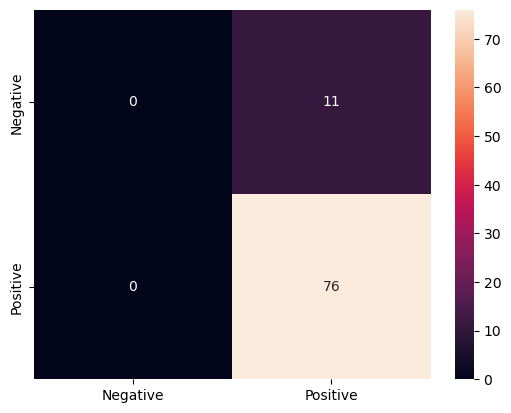

In [25]:
from sklearn import metrics
import seaborn as sns
#pred = voting.predict(x_test_tfidf)
cm=metrics.confusion_matrix(Y_test, y_test_pred)
cm = pd.DataFrame(cm, index = ["Negative", "Positive"], columns=["Negative", "Positive"])
sns.heatmap(cm, annot = True)
#plt.title("Confusion Matrix for Reviews Classifier")

In [44]:
# Analyzing the results
from sklearn.metrics import classification_report
report=classification_report(Y_test, y_test_pred,output_dict=True)
report

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 '1': {'precision': 0.8735632183908046,
  'recall': 1.0,
  'f1-score': 0.9325153374233129,
  'support': 76},
 'accuracy': 0.8735632183908046,
 'macro avg': {'precision': 0.4367816091954023,
  'recall': 0.5,
  'f1-score': 0.46625766871165647,
  'support': 87},
 'weighted avg': {'precision': 0.7631126965253006,
  'recall': 0.8735632183908046,
  'f1-score': 0.8146110993582963,
  'support': 87}}

By using the SVM Classifier we got an accuracy of 94.43%

In [45]:
# Logistic Regression is implemented using sklearn
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000, solver='saga')

In [46]:
# Fit the training data to the model
clf.fit(tf_x_train, Y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [47]:
# Predicting the test data
y_test_pred=clf.predict(tf_x_test)

In [48]:
# Analyzing the report
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_test_pred, output_dict=True)
report

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 '1': {'precision': 0.8735632183908046,
  'recall': 1.0,
  'f1-score': 0.9325153374233129,
  'support': 76},
 'accuracy': 0.8735632183908046,
 'macro avg': {'precision': 0.4367816091954023,
  'recall': 0.5,
  'f1-score': 0.46625766871165647,
  'support': 87},
 'weighted avg': {'precision': 0.7631126965253006,
  'recall': 0.8735632183908046,
  'f1-score': 0.8146110993582963,
  'support': 87}}

By using the LR classifier we got an accuracy of 92.20%

In [51]:
#the first is random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rmfr = RandomForestClassifier()
rmfr.fit(tf_x_train,Y_train)
predrmfr = rmfr.predict(tf_x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(Y_test,predrmfr))
print("Score:",round(accuracy_score(Y_test,predrmfr)*100,2))
print("Classification Report:\n",classification_report(Y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 0 11]
 [ 0 76]]
Score: 87.36
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.87      1.00      0.93        76

    accuracy                           0.87        87
   macro avg       0.44      0.50      0.47        87
weighted avg       0.76      0.87      0.81        87



C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(tf_x_train,Y_train)
preddt = dt.predict(tf_x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(Y_test,preddt))
print("Score:",round(accuracy_score(Y_test,preddt)*100,2))
print("Classification Report:\n",classification_report(Y_test,preddt))

Confusion Matrix for Decision Tree:
[[ 3  8]
 [ 6 70]]
Score: 83.91
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.27      0.30        11
           1       0.90      0.92      0.91        76

    accuracy                           0.84        87
   macro avg       0.62      0.60      0.60        87
weighted avg       0.83      0.84      0.83        87



In [33]:
#support vector machines
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(tf_x_train,Y_train)
predsvm = svm.predict(tf_x_test)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(Y_test,predsvm))
print("Score:",round(accuracy_score(Y_test,predsvm)*100,2))
print("Classification Report:\n",classification_report(Y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[ 0 11]
 [ 0 76]]
Score: 87.36
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.87      1.00      0.93        76

    accuracy                           0.87        87
   macro avg       0.44      0.50      0.47        87
weighted avg       0.76      0.87      0.81        87



C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
#count = CountVectorizer()

#idf_x_test = vectorizer.fit_transform(tf_x_test).toarray()

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])



#inverse document frequency
df_idf.sort_values(by=["idf_weights"])

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
place,1.922071
great,1.989512
good,2.195364
food,2.295448
would,2.360688
...,...
inspected,6.156178
inspired,6.156178
installed,6.156178
initial,6.156178


In [35]:
#Naive bayes classifier

# training the model on training set
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
 
# making predictions on the testing set
y_pred = gnb.predict(X_test)
 
# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(Y_test, y_pred)*100)

ValueError: could not convert string to float: 'welcome laundry heaven first huge rest clean see staff cleaning also see huge flat screen wall along vending machine filled laundry necessity snacksdrinks machine various size commercial grade washer dryer washer range dryer minute depends size always staff around nice helpful think also offer washingfolding service ask front desk parking usually issue unless peak work hour walk starbucks wait sit one table chair enjoy free wifi forget quarter place us laundry card refill visamastercard place put old laundromat shame closer home cleaner nicer around better quarter last wash pm'

In [52]:
# count matrix 
count_vector=cv.transform(post_process) 

# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [53]:
feature_names = cv.get_feature_names() 

#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 

#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
ivan,0.265083
said,0.242105
paper,0.212066
fork,0.212066
group,0.184484
...,...
frequent,0.000000
frequently,0.000000
fresh,0.000000
fresher,0.000000


In [54]:
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True) 

# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(post_process)

In [55]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] 

# place tf-idf values in a pandas data frame 
post_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
post_df.sort_values(by=["tfidf"],ascending=False)

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
ivan,0.265083
said,0.242105
paper,0.212066
fork,0.212066
group,0.184484
...,...
frequent,0.000000
frequently,0.000000
fresh,0.000000
fresher,0.000000


In [56]:
#from sklearn.feature_extraction.text import TfidfVectorizer
text_string = [' '.join(data['pre_process'])]
text_string

['probably one worst experience restaurant let start saying food good nothing wrong food chef amazing enjoyed food problem service made reservation ended getting around told needed wait enough chef totally fine understandable woman front seat party another party asked able sit group time told smaller group okay well reservation first sit care chef ready wanted sit order drink appetizer seated server ivan came promptly nice got first round drink thing went hill ordered sushi simple sushi salmon shrimp ordered roll crunch roll shrimp tempura roll brought yellowtail tuna veggie roll kindly said food ordered told wrong asked see sushi paper maybe marked wrong thing said threw paper away took sushi away huge attitude said would go try find paper well group could see back area pulled paper apron came said oh yeah guess fault brought guy wrong stuff okay tried explaining stuff finally come tasted perfect u ordered teppan got miso soup done got salad none u fork pretty sure maybe u knew use ch

In [57]:
from wordcloud import STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud
import re

d = {}
for a, x in post_df.values:
    d[a] = x

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
#text_string = re.sub('[^a-zA-Z]', '', str(text_string))
#print(text_string)

#text = post_df.loc['tfidf'].sort_values(ascending=False)
#text_todict = post_df.loc

#letterjumble = WordCloud(min_word_length=4, background_color='white')
#letterjumble.generate_from_frequencies(frequencies=text)

#stop_words = ["went", "really", "go", "going", "place", "day", "night", "one", "alway", "say", "make", "review", "got", "took", "around", "much", "came"] + list(STOPWORDS)
#graphic_df = WordCloud(stopwords = stop_words, min_word_length =4, background_color='white').generate(data['text'].to_string())

ValueError: not enough values to unpack (expected 2, got 1)

In [58]:
from wordcloud import STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud
import re

#text_string = re.sub('[^a-zA-Z]', '', str(text_string))
#print(text_string)

stop_words = ["went", "really", "go", "going", "place", "day", "night", "one", "alway", "say", "make", "review", "got", "took", "around", "much", "came"] + list(STOPWORDS)
text = WordCloud(stopwords = stop_words, min_word_length =4, background_color='white').generate(data['pre_process'].to_string())

Create a Word Cloud https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f; https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

(-0.5, 399.5, 199.5, -0.5)

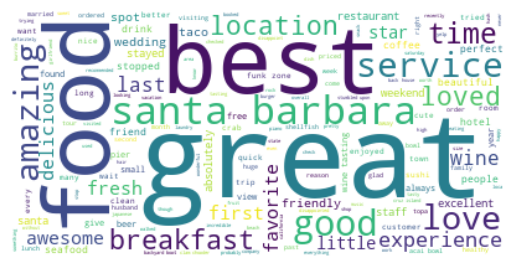

In [59]:

plt.imshow(text, interpolation='bilinear')
plt.axis("off")

In [60]:
# neg_reviews = data.loc[data['pre_process']]---- value 0, 
# pos_reviews = and another one for value 1

In [61]:
pos_reviews = data.loc[(data['label'] >= 1)]
pos_reviews.head()

,text,stars,label,pre_process
36,Great breakfast place - got the Benedict and s...,5,1,great breakfast place got benedict substituted...
37,Cute little stop on the pier. The view of the ...,5,1,cute little stop pier view city night beyond b...
38,"The wines were very good, and the view is incr...",4,1,wine good view incredible fyi food small chees...
39,So good. Real Mexico City style. Alambres are ...,5,1,good real mexico city style alambres amazing m...
40,I stumbled on this for breakfast. I had a Back...,5,1,stumbled breakfast backyard bowl yummy large p...


In [62]:
neg_reviews = data.loc[(data['label'] == 0)]
neg_reviews.head()

,text,stars,label,pre_process
0,Probably one of the WORST experiences I''ve ha...,1,0,probably one worst experience restaurant let s...
1,I was SO disappointed by this place! \n\nNorma...,2,0,disappointed place normally find place near wa...
2,I''m a big fan of the food here but recently n...,1,0,big fan food recently noticed great job washin...
3,Sushi eaters beware. My family and I just ate ...,2,0,sushi eater beware family ate family ordered c...
4,"In my experience, the staff was a disappointme...",1,0,experience staff disappointment employee try t...


In [63]:
pos_text_string = [' '.join(pos_reviews['pre_process'])]
pos_text_string

['great breakfast place got benedict substituted bacon avocado flavor point probably swapped toast english muffin cute little stop pier view city night beyond beautiful wine tasting option great wine newbie like employee friendly helpful choosing right wine try wine good view incredible fyi food small cheese plate nice enjoying wine flight unfortunately one worker pathetic young man clearly motivation work asked wine would say name year plop bottle front u could read honestly quite rude inconveniencing lady working gave u nice description wine happy helped u instead recommend going relaxing wonderful view please ask one girl help good real mexico city style alambres amazing mexican restaurant authentic new favorite place santa barbara stumbled breakfast backyard bowl yummy large pretty big granola fabulous crunchy overly sweet great find restaurant serf organic food tomorrow going try island bowl pricing worth better eating pancake aunt stayed night december location great close state 

In [64]:
pd.options.display.max_colwidth = 10000 #Changes the number of characters in a cell so that the contents don't get truncated (default is 50)

L = pos_text_string

#create new df 
pos_df = pd.DataFrame({'col':pos_text_string})
print (pos_df)

(-0.5, 399.5, 199.5, -0.5)

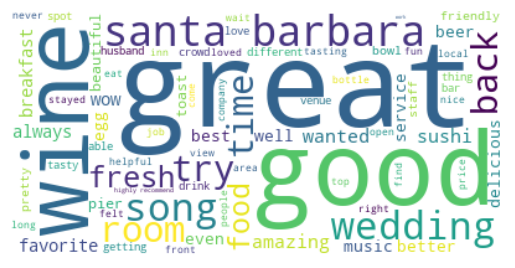

In [65]:

stop_words = ["went", "really", "go", "going", "place", "day", "night", "one", "alway", "say", "make", "review", "got", "took", "around", "much", "came"] + list(STOPWORDS)
text = WordCloud(max_words=75, stopwords = stop_words, min_word_length =3, background_color='white').generate(pos_df['col'].to_string())
plt.imshow(text, interpolation='bilinear')
plt.axis("off")


In [66]:
neg_text_string = [' '.join(neg_reviews['pre_process'])]
neg_text_string

['probably one worst experience restaurant let start saying food good nothing wrong food chef amazing enjoyed food problem service made reservation ended getting around told needed wait enough chef totally fine understandable woman front seat party another party asked able sit group time told smaller group okay well reservation first sit care chef ready wanted sit order drink appetizer seated server ivan came promptly nice got first round drink thing went hill ordered sushi simple sushi salmon shrimp ordered roll crunch roll shrimp tempura roll brought yellowtail tuna veggie roll kindly said food ordered told wrong asked see sushi paper maybe marked wrong thing said threw paper away took sushi away huge attitude said would go try find paper well group could see back area pulled paper apron came said oh yeah guess fault brought guy wrong stuff okay tried explaining stuff finally come tasted perfect u ordered teppan got miso soup done got salad none u fork pretty sure maybe u knew use ch

In [67]:
pd.options.display.max_colwidth = 10000 #Changes the number of characters in a cell so that the contents don't get truncated (default is 50)

N = neg_text_string

#create new df 
neg_df = pd.DataFrame({'col':neg_text_string})
neg_df

col
0  probably one worst experience restaurant let start saying food good nothing wrong food chef amazing enjoyed food problem service made reservation ended getting around told needed wait enough chef totally fine understandable woman front seat party another party asked able sit group time told smaller group okay well reservation first sit care chef ready wanted sit order drink appetizer seated server ivan came promptly nice got first round drink thing went hill ordered sushi simple sushi salmon shrimp ordered roll crunch roll shrimp tempura roll brought yellowtail tuna veggie roll kindly said food ordered told wrong asked see sushi paper maybe marked wrong thing said threw paper away took sushi away huge attitude said would go try find paper well group could see back area pulled paper apron came said oh yeah guess fault brought guy wrong stuff okay tried explaining stuff finally come tasted perfect u ordered teppan got miso soup done got salad none u fork pretty sure maybe u knew use chopstick asked fork said yeah problem well waited minute saw find server ask help ended eating finger finally see ivan asked fork said honestly need right food cooked excuse furious would even come back attitude girl needed fork told yes need almost got go find anyways chef come food turned good ivan found minute girl group asked box included took minute get ended eating last bit food going take home brought box said sorry need box anymore finished going take home thank politely came back ok well maybe take plate away stop changing mind hell point done trying nice half hour glad leaving ivan rude girl group hope go back probably ivan always try give people benefit doubt maybe bad day day bad come work mean rude customer work public believe hard always please everyone unacceptable rude people disappointed place normally find place near water fresh albeit simple delicious seafood unfortunately case shanty sea price super inflated seafood fresh first major indicator group dine elsewhere ordered crab cake arrived lukewarm greasy overall appetizing think next time skip pier go straight fresh clambake big fan food recently noticed great job washing beer glass see bubble sticking inside glass know something would probably give place four star sushi eater beware family ate family ordered cooked item menu fine hand ordered sushi bento box sushi made incredibly ill taste bad fact got sick made star experience new sushi frequently get sashimi restaurant time however stomach killing come restaurant make sure get cooked food experience staff disappointment employee try take complicated order wanted baked salmon avocado cucumber simple customized order ordering waitress power take order felt complicated walked away pas u another waitress result restaurant lack communication mannerism recommend place order complicated take pas manager would advise staying hotel called speak manager friend put post manager rude really wanted like coffee obviously location nice parking lot important parking trendiest area santa barbara b vibe typical coffee shop dcor service good could get finish aftertaste coffee review based purely last experience place employee extremely rude therefore felt necessary write review local born raised come many time friend visiting town wanted show around funk zone stopped grab glass wine two u decided use restroom apparently sign door say person use restroom time however see sign honest mistake part friend went bathroom together le second going restroom heard loud banging door happened three time minute max restroom even chance wash hand yet friend opened door see banging door drunk girl come running screaming u proceeded pull pant front u started peeing never seen anything like accused u taking long causing pee floor walked outside saw puddle pee floor employee came u told u together said sorry know went back grab glass wine ordered tried find place sit walking doorway girl bumped girl peed floor called racist name walked outside ignored dec

(-0.5, 399.5, 199.5, -0.5)

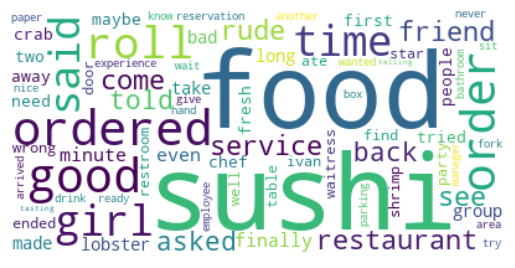

In [68]:
stop_words = ["went", "really", "go", "going", "place", "day", "night", "one", "alway", "say", "make", "review", "got", "took", "around", "much", "came"] + list(STOPWORDS)
text = WordCloud(max_words=75, stopwords = stop_words, min_word_length =3, background_color='white').generate(neg_df['col'].to_string())
plt.imshow(text, interpolation='bilinear')
plt.figure
plt.axis("off")

In [69]:
neg_df['col'].value_counts()

probably one worst experience restaurant let start saying food good nothing wrong food chef amazing enjoyed food problem service made reservation ended getting around told needed wait enough chef totally fine understandable woman front seat party another party asked able sit group time told smaller group okay well reservation first sit care chef ready wanted sit order drink appetizer seated server ivan came promptly nice got first round drink thing went hill ordered sushi simple sushi salmon shrimp ordered roll crunch roll shrimp tempura roll brought yellowtail tuna veggie roll kindly said food ordered told wrong asked see sushi paper maybe marked wrong thing said threw paper away took sushi away huge attitude said would go try find paper well group could see back area pulled paper apron came said oh yeah guess fault brought guy wrong stuff okay tried explaining stuff finally come tasted perfect u ordered teppan got miso soup done got salad none u fork pretty sure maybe u knew use chop

In [70]:
# https://stackoverflow.com/questions/38465478/wordcloud-from-data-frame-with-frequency-python
# https://stackoverflow.com/questions/57826063/how-to-create-a-wordcloud-according-to-frequencies-in-a-pandas-dataframe
# Looking up how to create a wordcloud based on word frequency
d = {}
for a, x in neg_df.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# Look at an article to figure out word frequency: https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

# create a dictionary of word frequencies
text = ' '.join(neg_text_string) # create string out of a list
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)
text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
# 
#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:5])
print(list(rel_freq.items())[:5])

plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()